In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from PartialIdentification import PartialIdentification
import utils

In [2]:
proxy_cols = ['VKORC1..4451.', 'VKORC1.2255.', 'VKORC1.3730.', 'VKORC1.1542.', 'VKORC1.1173.', 'VKORC1.497.', 'VKORC1..1639.', 'Acetaminophen.', 'Acetaminophen.hi.dose.', 'Simvastatin.', 'Atorvastatin.', 'Fluvastatin.', 'Lovastatin.', 'Pravastatin.', 'Rosuvastatin.', 'Cerivastatin.', 'Amiodarone.', 'Carbamazepine.', 'Phenytoin.', 'Rifampin.', 'Sulfonamide.Antibiotics.', 'Macrolide.Antibiotics.', 'Anti.fungal.Azoles.', 'Herbal.Medications..Vitamins..Supplements.']
primary = pd.read_csv('data/warfarin/primary.csv')
primary['target'] = primary['therapeut_dose'] > 35
auxiliary = pd.read_csv('data/warfarin/auxiliary.csv')

X_cols = list(set(primary.columns).difference(('race', 'target', 'therapeut_dose')))

base_rfc = RandomForestRegressor()
base_rfc.fit(primary[X_cols], primary['therapeut_dose'])
primary['prediction'] = base_rfc.predict(primary[X_cols]) > 35


np.random.seed(42)

PI = PartialIdentification(primary,
                           auxiliary,
                           'target',
                           X_cols,
                           'race',
                           'prediction',
                           proxy_cols)

# Set of potential true positive rates for White protected class

In [3]:
PI.tpr_reading('White')

{'lower_bound': 0.8985148514851485,
 'expected_value': 0.9619205298013246,
 'upper_bound': 1.0}

# Set of potential true positive rates for Asian protected class

In [4]:
PI.tpr_reading('Asian')

{'lower_bound': 0.0, 'expected_value': 0.7164179104477613, 'upper_bound': 1.0}

# Set of potential disparities in true positive rates between White protected class and all others combined

In [5]:
PI.tpr_disparity('White')

{'lower_bound': -0.10148514851485146,
 'expected_value': 0.05154317131075847,
 'upper_bound': 1.0}

# Set of potential disparities in true positive rates between African-American and White protected classes

In [6]:
PI.tpr_disparity('Black','White')

{'lower_bound': -1.0,
 'expected_value': 0.038079470198675414,
 'upper_bound': 0.10148514851485146}

# Plot partial identification sets for most bias metrics

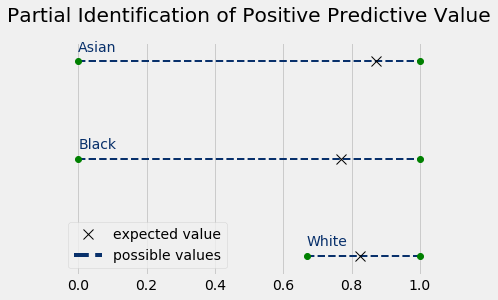

In [7]:
title = 'Partial Identification of Positive Predictive Value'
protected_class_names = ['White','Black','Asian']
intervals = [PI.ppv_reading(protected_class) for protected_class in protected_class_names]
fig = utils.plot_intervals(title, protected_class_names, intervals)

# Plot partial identification sets for most disparities in bias metrics

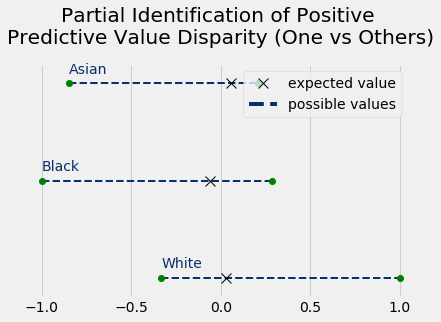

In [12]:
title = 'Partial Identification of Positive \nPredictive Value Disparity (One vs Others)'
protected_class_names = ['White','Black','Asian']
intervals = [PI.ppv_disparity(protected_class) for protected_class in protected_class_names]
fig = utils.plot_intervals(title, protected_class_names, intervals, lower_limit=-1)